In [1]:
import pandas as pd

import seaborn as sns

sns.set_context("talk")
import matplotlib.pyplot as plt
import statsmodels

import statsmodels.formula.api as smf
import numpy as np

plt.style.use("ggplot")

In [2]:
data=pd.read_csv('clean_data/final_dataset.csv')
data[['income_census','pop_census']]=np.log(data[['income_census','pop_census']])

In [3]:
data.columns
y = "povrate"
x = [
    "pop_census",
    "nhwrate",
    "blkrate",
    "asianrate",
    "hisprate",
    "nativerate",
    "state_mormon",
    "altitude",
    "mormon",
    "income_census"
]

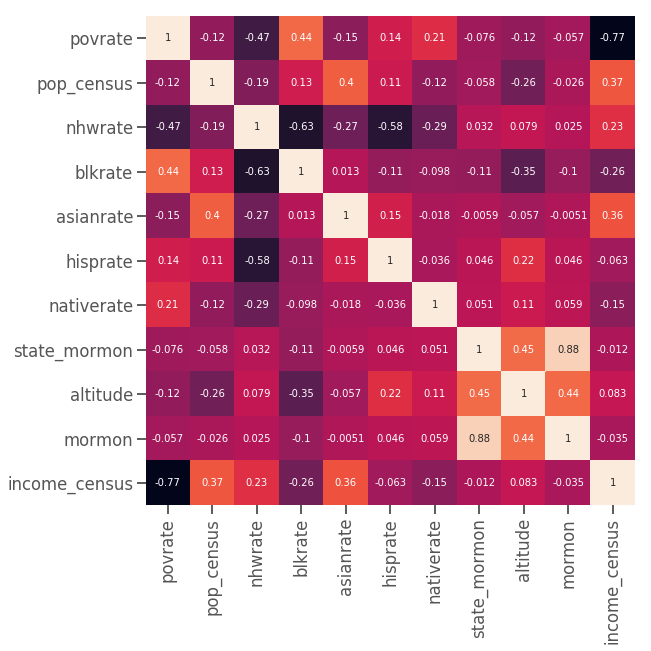

In [4]:
plt.figure(figsize=(9,9))
sns.heatmap(data[[y]+x].corr(),annot=True,square=True,cbar=False)

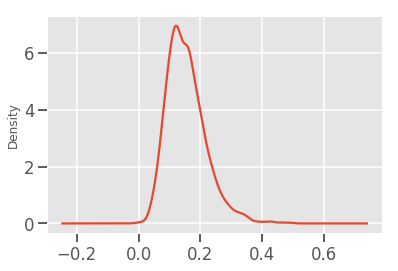

In [5]:
#lognormal
data['povrate'].plot.kde()

In [6]:
data.povrate.describe()

count    3126.000000
mean        0.154988
std         0.063418
min         0.000000
25%         0.110022
50%         0.146984
75%         0.190004
max         0.492731
Name: povrate, dtype: float64

In [7]:
import statsmodels.api as sm


def regress(
    x,
    y,
    model="ols",
    plot=False,
    summary=False,
    show_nonsignificant=False,
    data=data,
    log=False,
):
    # Weighted regression due to different pop size in each county. Lower pops will be noisier.
    if log:
        expr = f"np.log({y})~" + "+".join(x)
        logiflog = np.log
    else:
        expr = f"({y})~" + "+".join(x)
        logiflog = lambda x: x
    if model == "glm":
        ret = smf.glm(
            expr,
            data=data,
            family=sm.families.Gaussian(link=sm.families.links.log()),
            var_weights=data.pop_census,
        ).fit()
    elif model == "wls":
        ret = smf.ols(expr, data=data).fit()
    else:
        ret = smf.wls(expr, data=data, weights=data["pop_census"]).fit()
    if summary:
        display(ret.summary())
    if plot:
        if model == "glm":
            pred = logiflog(ret.predict(data[x]).squeeze())
        else:
            pred = logiflog(ret.predict(data[x]).squeeze())
        display(plt.scatter(data[y], pred))
        max_y = max(data[y])
        min_y = min(data[y])
        plt.plot([min_y, max_y], [min_y, max_y], c="blue")
    df = pd.concat([ret.params, ret.pvalues], axis=1)

    df.columns = ["coefficients", "pvalue"]
    df["pvalue"] = df["pvalue"].round(3)
    df["pvalue"] = np.where(
        df.pvalue < 0.05, df.pvalue.astype(str) + "*", df.pvalue.astype(str)
    )
    if not show_nonsignificant:
        df = df[df.pvalue.str.contains("\*")]

    mean_frame = data[x].mean().to_frame().T
    if 'state' in x:
        mean_frame['state']='Utah'
    mean_predicted = ret.predict(mean_frame).values
    display(f"Baseline value: {np.round(mean_predicted,2).squeeze()}")

    for var in df.index:
        if var != "Intercept" and "state[" not in var:
            df.loc[var, "var_max_value"] = data[var].max()
            df.loc[var, "var_mean_value"] = data[var].mean()
            df.loc[var, "effect_mean_to_max"] = (
                ret.predict(mean_frame.assign(**{var: data[var].max()})).values
                - mean_predicted
            )
    # df["effect_pc"] = 100 * (df.effect_mean_to_max) / mean_predicted
    df = df.round(3)

    return df, ret


t, mod = regress(x, y, model="glm", log=False)
t

'Baseline value: 0.15'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,12.109,0.0*,NaN,NaN,NaN
pop_census,0.045,0.0*,16.078,10.225,0.044
state_mormon,-0.258,0.034*,0.690,0.022,-0.023
altitude,0.000,0.0*,4008.285,424.280,0.023
mormon,-0.000,0.014*,1007.860,21.801,-0.031
income_census,-1.426,0.0*,11.073,9.996,-0.116


In [8]:
#Substract income effect from poverty
df,mod=regress(['income_census'],y,model='glm')
data['resid_pov']=mod.resid_response
y2='resid_pov'

'Baseline value: 0.15'

In [9]:
data.resid_pov.describe()

count    3126.000000
mean       -0.001242
std         0.037213
min        -0.229670
25%        -0.025573
50%        -0.003878
75%         0.021030
max         0.170191
Name: resid_pov, dtype: float64

In [10]:
# #Keep state as per BIC and AIC
# df,mod=regress(x,y2,model='glm')
# df
# #???? (weird numerical error)

In [11]:
df,mod=regress(x,y2,model='ols',)
df

'Baseline value: -0.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
pop_census,0.006,0.0*,16.078,10.225,0.035
altitude,0.000,0.0*,4008.285,424.280,0.035
mormon,-0.000,0.0*,1007.860,21.801,-0.055


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              resid_pov   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     87.71
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          8.91e-160
Time:                        16:26:46   Log-Likelihood:                 6240.6
No. Observations:                3126   AIC:                        -1.246e+04
Df Residuals:                    3115   BIC:                        -1.239e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0720      0.047     -1.542      0.123      -0.163       0.020
pop_census        0.0059      0.001     11.629      0.000       0.005       0.007
nhwrate          -0.0474      0.036     -1.324      0.186      -0.117       0.023
blkrate           0.0427      0.036      1.199      0.231      -0.027       0.112
asianrate        -0.0052      0.052     -0.100      0.920      -0.108       0.097
hisprate         -0.0213      0.036     -0.597      0.550      -0.091       0.049
nativerate        0.0424      0.039      1.081      0.280      -0.035       0.119
state_mormon     -0.0242      0.017     -1.391      0.164      -0.058       0.010
altitude       9.736e-06   1.54e-06      6.308      0.000    6.71e-06    1.28e-05
mormon        -5.422e-05   1.47e-05     -3.688      0.000    -8.3e-05   -2.54e-05
income_census     0.0043      0.003      1.290      0.197      -0.002       0.011
==============================================================================
Omnibus:                      222.477   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1056.973
Skew:                           0.133   Prob(JB):                    3.03e-230
Kurtosis:                       5.836   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: -0.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
pop_census,0.006,0.0*,16.078,10.225,0.034
altitude,0.000,0.0*,4008.285,424.280,0.035
mormon,-0.000,0.0*,1007.860,21.801,-0.053


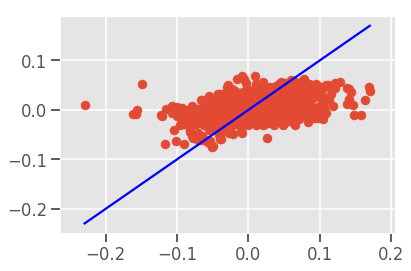

In [12]:
#Not much difference from plain OLS
df,mod=regress(x,y2,model='wls',plot=True,summary=True)
df

In [13]:
target = data.query('county=="Salt Lake"')[x].reset_index(drop=True)
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": mod.predict(target)[0],
        "baseline": data[y].values[0],
        "no_mormons": mod.predict(no_mormons)[0],
        "no_mormons-predicted": mod.predict(no_mormons)[0] - mod.predict(target)[0],
    }
)
# Baseline is 0.105 because it's not the residual

predicted              -0.021632
baseline                0.105875
no_mormons              0.010533
no_mormons-predicted    0.032165
dtype: float64

# Effect of mormon
After controlling for income, the effect of mormonism is similar to the effect of everything else: tiny. Full mormonisation would yield negligible gains.

But what if? Mormon->Income?

'Baseline value: 10.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,9.767,0.0*,NaN,NaN,NaN
mormon,-0.000,0.002*,1007.860,21.801,-0.127
nhwrate,0.275,0.0*,1.000,0.788,0.058
blkrate,-0.168,0.0*,0.861,0.089,-0.130
asianrate,3.753,0.0*,0.522,0.011,1.918
nativerate,-0.278,0.0*,0.889,0.017,-0.242


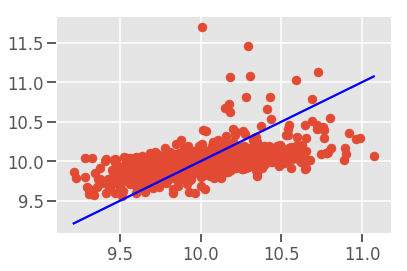

In [14]:
df,mod=regress(['mormon',"nhwrate","blkrate","asianrate","nativerate"],'income_census',plot=True)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              resid_pov   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     87.71
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          8.91e-160
Time:                        16:26:47   Log-Likelihood:                 6240.6
No. Observations:                3126   AIC:                        -1.246e+04
Df Residuals:                    3115   BIC:                        -1.239e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0720      0.047     -1.542      0.123      -0.163       0.020
pop_census        0.0059      0.001     11.629      0.000       0.005       0.007
nhwrate          -0.0474      0.036     -1.324      0.186      -0.117       0.023
blkrate           0.0427      0.036      1.199      0.231      -0.027       0.112
asianrate        -0.0052      0.052     -0.100      0.920      -0.108       0.097
hisprate         -0.0213      0.036     -0.597      0.550      -0.091       0.049
nativerate        0.0424      0.039      1.081      0.280      -0.035       0.119
state_mormon     -0.0242      0.017     -1.391      0.164      -0.058       0.010
altitude       9.736e-06   1.54e-06      6.308      0.000    6.71e-06    1.28e-05
mormon        -5.422e-05   1.47e-05     -3.688      0.000    -8.3e-05   -2.54e-05
income_census     0.0043      0.003      1.290      0.197      -0.002       0.011
==============================================================================
Omnibus:                      222.477   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1056.973
Skew:                           0.133   Prob(JB):                    3.03e-230
Kurtosis:                       5.836   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: -0.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
pop_census,0.006,0.0*,16.078,10.225,0.034
altitude,0.000,0.0*,4008.285,424.280,0.035
mormon,-0.000,0.0*,1007.860,21.801,-0.053


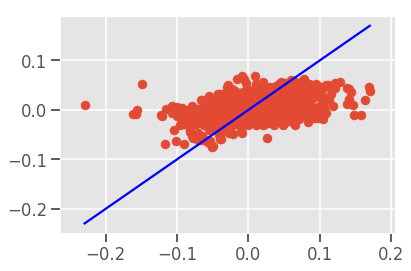

In [15]:
x2=x+['state']
#Keep state as per BIC and AIC
df,mod=regress(x,y2,model='wls',plot=True,summary=True)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              resid_pov   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     20.82
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          7.89e-180
Time:                        16:26:47   Log-Likelihood:                 6379.5
No. Observations:                3126   AIC:                        -1.264e+04
Df Residuals:                    3066   BIC:                        -1.228e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0948      0.063     -1.509      0.131      -0.218       0.028
state[T.Alaska]                  -0.0334      0.009     -3.646      0.000      -0.051      -0.015
state[T.Arizona]                 -0.0154      0.010     -1.605      0.109      -0.034       0.003
state[T.Arkansas]                 0.0026      0.005      0.473      0.636      -0.008       0.013
state[T.California]              -0.0062      0.006     -0.978      0.328      -0.019       0.006
state[T.Colorado]                -0.0202      0.007     -2.819      0.005      -0.034      -0.006
state[T.Connecticut]             -0.0169      0.012     -1.396      0.163      -0.041       0.007
state[T.Delaware]                -0.0197      0.019     -1.050      0.294      -0.057       0.017
state[T.District of Columbia]     0.0607      0.032      1.887      0.059      -0.002       0.124
state[T.Florida]                 -0.0061      0.006     -1.087      0.277      -0.017       0.005
state[T.Georgia]                 -0.0076      0.005     -1.644      0.100      -0.017       0.001
state[T.Hawaii]                  -0.0837      0.023     -3.565      0.000      -0.130      -0.038
state[T.Idaho]                   -0.0129      0.007     -1.953      0.051      -0.026    5.06e-05
state[T.Illinois]                -0.0093      0.005     -1.786      0.074      -0.020       0.001
state[T.Indiana]                 -0.0181      0.005     -3.375      0.001      -0.029      -0.008
state[T.Iowa]                    -0.0189      0.005     -3.583      0.000      -0.029      -0.009
state[T.Kansas]                  -0.0195      0.005     -3.684      0.000      -0.030      -0.009
state[T.Kentucky]                 0.0193      0.005      3.805      0.000       0.009       0.029
state[T.Louisiana]                0.0078      0.006      1.398      0.162      -0.003       0.019
state[T.Maine]                    0.0016      0.009      0.182      0.856      -0.016       0.019
state[T.Maryland]                -0.0285      0.008     -3.702      0.000      -0.044      -0.013
state[T.Massachusetts]            0.0016      0.010      0.170      0.865      -0.017       0.020
state[T.Michigan]                -0.0023      0.005     -0.425      0.671      -0.013       0.008
state[T.Minnesota]               -0.0179      0.005     -3.289      0.001      -0.029      -0.007
state[T.Mississippi]              0.0029      0.005      0.557      0.577      -0.007       0.013
state[T.Missouri]                -0.0081      0.005     -1.597      0.110      -0.018       0.002
state[T.Montana]                 -0.0061      0.006     -0.977      0.329      -0.018       0.006
state[T.Nebraska]                -0.0234      0.005     -4.297      0.000      -0.034      -0.013
state[T.Nevada]                  -0.0160     

'Baseline value: -0.01'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
state[T.Alaska],-0.033,0.0*,NaN,NaN,NaN
state[T.Colorado],-0.020,0.005*,NaN,NaN,NaN
state[T.Hawaii],-0.084,0.0*,NaN,NaN,NaN
state[T.Indiana],-0.018,0.001*,NaN,NaN,NaN
state[T.Iowa],-0.019,0.0*,NaN,NaN,NaN
state[T.Kansas],-0.020,0.0*,NaN,NaN,NaN
state[T.Kentucky],0.019,0.0*,NaN,NaN,NaN
state[T.Maryland],-0.029,0.0*,NaN,NaN,NaN
state[T.Minnesota],-0.018,0.001*,NaN,NaN,NaN
state[T.Nebraska],-0.023,0.0*,NaN,NaN,NaN


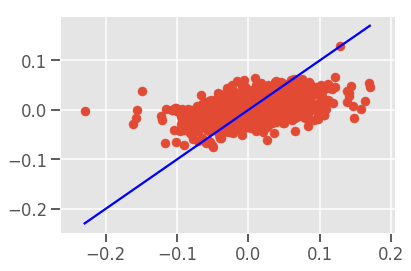

In [16]:
df,mod=regress(x2,y2,model='wls',plot=True,summary=True)
df

In [17]:
target = data.query('county=="Salt Lake"')[x2].reset_index(drop=True)
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": mod.predict(target)[0],
        "baseline": data[y].values[0],
        "no_mormons": mod.predict(no_mormons)[0],
        "no_mormons-predicted": mod.predict(no_mormons)[0] - mod.predict(target)[0],
    }
)

predicted              -0.023291
baseline                0.105875
no_mormons              0.008216
no_mormons-predicted    0.031506
dtype: float64

# Again, negligible
Final prediction from linear models: Full 1000->0 demormonisation would lead to a rise in poverty of 3.2 percentage points in Utah

# Let's try catboost

### Without income (on poverty)

In [18]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor,Dataset
from lightgbm import plot_importance

ITERATIONS=100
def get_bayes_tuner(cat_feat=[]):
    search_space = {
 
        "num_leaves":(10,40),
        "min_child_samples":(5,50),
        "learning_rate":(0.01,0.5,"uniform"),
        "n_estimators":(10,500),
        "min_split_gain":(0.,1.,"uniform"),
        "colsample_bytree":(0.5,0.8,1)

    }
    return BayesSearchCV(
        estimator=LGBMRegressor(n_jobs=6),
        search_spaces=search_space,
        cv=KFold(n_splits=10, shuffle=True, random_state=42),
        n_jobs=2,
        n_iter=ITERATIONS,
        verbose=3,
        refit=True,
        random_state=42,
        scoring="r2",
        fit_params={'categorical_feature':cat_feat}
    )

In [19]:
data['state_factor'],factor_array=pd.factorize(data.state)

In [20]:
x3=x2[::1]
x3.remove('state')
x3.append('state_factor')
x3.append('income_census')

In [21]:
cat_pos = np.where(data[x3].dtypes == int)[0].tolist()
pool = Dataset(
    data=data[x3], categorical_feature=cat_pos, weight=data.pop_census, label=data[y]
)
bayes_tuner = get_bayes_tuner(cat_pos)
cat = bayes_tuner.fit(data[x3], data[y])

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.2s finished


In [22]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score',ascending=False)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_split_gain,param_n_estimators,param_num_leaves,params
89,0.794135,0.748810,0.754060,0.725312,0.790434,0.804430,0.767434,0.761164,0.809687,0.759818,...,0.013047,0.006154,0.001605,0.8,0.077174,5,0.000000,479,10,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
73,0.799899,0.745077,0.761327,0.727300,0.793769,0.800938,0.765450,0.757416,0.806336,0.750109,...,0.110295,0.006895,0.004438,0.5,0.085188,5,0.000000,471,10,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
72,0.789260,0.743336,0.758494,0.734033,0.786865,0.801292,0.769958,0.760960,0.807837,0.755202,...,0.209558,0.008722,0.010474,0.8,0.073484,5,0.000000,500,10,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
93,0.795469,0.744149,0.753867,0.726546,0.791806,0.803184,0.766958,0.748164,0.810267,0.763257,...,0.023711,0.005100,0.000346,0.8,0.040118,5,0.000000,492,10,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
88,0.804146,0.746170,0.756635,0.732518,0.789880,0.804350,0.760933,0.747138,0.804389,0.756647,...,0.124330,0.005508,0.000708,0.8,0.074078,5,0.000000,500,10,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
54,0.790191,0.744982,0.749873,0.733877,0.788836,0.803067,0.762513,0.752049,0.819947,0.757154,...,0.013713,0.005043,0.000701,0.8,0.098864,5,0.000000,413,10,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
99,0.794658,0.744039,0.745428,0.732517,0.792299,0.804513,0.764650,0.755044,0.808100,0.759043,...,0.179706,0.008709,0.011833,0.5,0.073526,5,0.000000,481,10,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
75,0.791146,0.738096,0.748631,0.724911,0.790025,0.802889,0.770770,0.766710,0.807084,0.755663,...,0.021820,0.006431,0.001945,0.5,0.084533,5,0.000000,469,10,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
87,0.787109,0.745151,0.755437,0.729666,0.798693,0.805679,0.764011,0.745846,0.801025,0.760621,...,0.125174,0.005311,0.000597,0.5,0.077168,5,0.000000,481,10,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
50,0.797440,0.736227,0.742945,0.729292,0.788638,0.801473,0.762531,0.757134,0.808038,0.768236,...,0.014351,0.005096,0.000638,0.8,0.111029,5,0.000000,466,10,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."


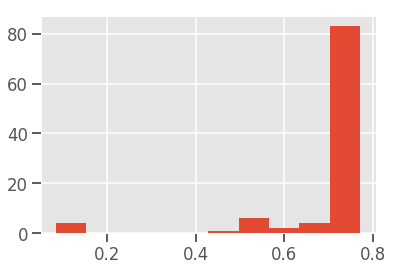

In [23]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score').mean_test_score.hist()

Catboost is a nonlinear model, so we lose explainability. Feature importances in tree models are commonly used to try to interpret them, but those may be biased by multicollinearity. Let's try to see what we get from them first:

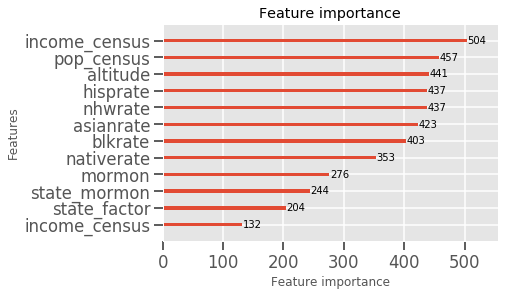

In [24]:
plot_importance(cat.best_estimator_)

Again, mormon comes as relatively not important

These feature importances may be fake news because of multicollinearity issues, so we turn to SHAP to see what features drive this model.

[SHAP](https://arxiv.org/pdf/1705.07874.pdf) produces a score for each pair of (feature,sample), indicating how much that feature contributed in that particular case. In effect SHAP is solving a credit assignment problem.

Unlike with the coefficients in OLS, here we have scores per pair of features, which make it more important to visualise what is going on on a case by case basis to see if trends emerge

In [25]:
import shap
shap.initjs()


In [26]:
explainer=shap.TreeExplainer(cat.best_estimator_)
shaps=explainer.shap_values(data[x3])

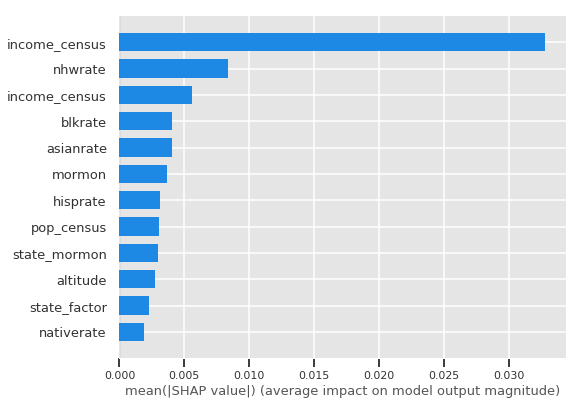

In [27]:
shap.summary_plot(shaps,data[x3], plot_type="bar")

Also in CatBoost, mormons are not a significant variable

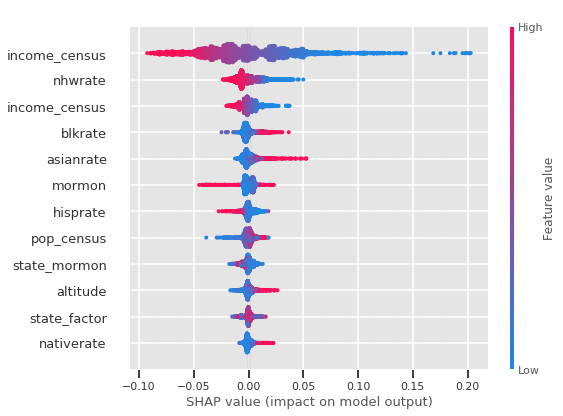

In [28]:
# This plot measures the impact of a variable on poverty. Each point is a particular county.
# The y-size of each row represents the density of points at that particular point
# High SHAP values mean in that case the variable in that case contributed to a higher poverty rate
# The sense in which it contributed can be glanced from the colorbar
# For example, the blue points in income_census mean that when income was low, the SHAP value was high (higher poverty)
# Positive values mean that in that part
shap.summary_plot(shaps,data[x3])

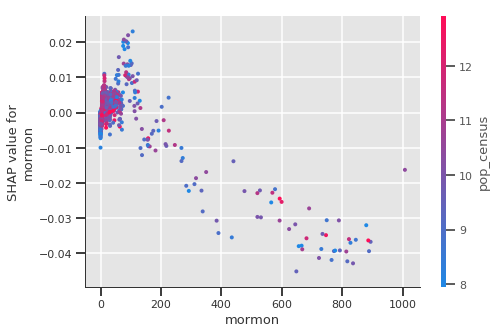

In [29]:
shap.dependence_plot("mormon", shaps,data[x3],interaction_index=0)

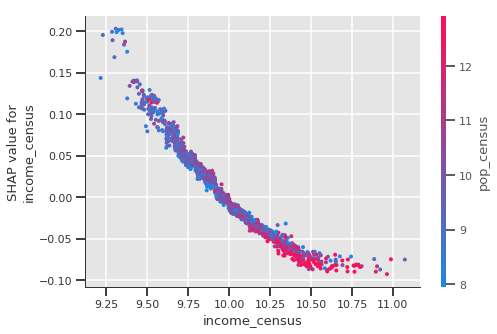

In [30]:
shap.dependence_plot("income_census", shaps,data[x3])

In [32]:
#Salt Lake
shap.force_plot(explainer.expected_value,shaps[2778,:],data[x3].loc[2778,:])

In [33]:
shap.force_plot(explainer.expected_value,shaps[217,:],data[x3].loc[217,:])

In [35]:
data.query('county=="San Francisco"')

,state,county,povrate,pop_census,income_census,nhwrate,blkrate,asianrate,nativerate,hisprate,...,mortality_alcohol,mortality_drug_us,mortality_self_ha,mortality_interpe,mortality,outcomes,state_mormon,altitude,resid_pov,state_factor
217,California,San Francisco,0.118615,13.567917,10.724984,0.420773,0.060655,0.333613,0.002651,0.147085,...,7.41,19.12,12.43,6.54,0.234244,0.228563,0.020478,15.562419,0.068476,4


In [36]:
target = data.query('county=="Salt Lake"')[x3]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].values[0],
        "no_mormons": cat.predict(no_mormons)[0],
         "diff":-cat.predict(target)[0]+cat.predict(no_mormons)[0]
    }
)

predicted     0.106107
baseline      0.105875
no_mormons    0.132164
diff          0.026057
dtype: float64

In [37]:
x4=x3[::1]
x4.remove('income_census')

With catboost the effect a bit less, just 2.6 percentage points.

## Without income, on the residual

In [38]:
#Catboost on the residual of poverty~income
cat_pos=np.where(data[x4].dtypes==int)[0].tolist()
cat_residual=get_bayes_tuner(cat_feat=cat_pos)
cat_residual.fit(data[x4],data[y2])


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.6s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    4.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.6s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished


BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=6, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params={'categorical_feature': [9]}, iid=True, n_iter=100,
       n_jobs=2, n_points=1, optimizer_kwargs=None,
       pre_dispatch='2*n_jobs', random_state=42, refit=True,
       return_train_score=False, scoring='r2',
       search_spaces={'num_leaves': (10, 40), 'min_child_samples': (5, 50), 'learning_rate': (0.01, 0.5, 'uniform'), 'n_estimators': (10, 500), 'min_split_gain': (0.0, 1.0, 'uniform'), 'colsample_bytree': (0.5, 0.8, 1)},
       verbose=3)

In [39]:
cat_residual.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'min_child_samples': 5,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'num_leaves': 40}

In [40]:
pd.DataFrame(cat_residual.cv_results_).sort_values('mean_test_score',ascending=False)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_split_gain,param_n_estimators,param_num_leaves,params
50,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.032844,0.007186,0.000933,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
60,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.016897,0.007335,0.000507,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
73,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.012951,0.006163,0.000380,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
72,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.005158,0.006403,0.000234,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
69,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.014538,0.006460,0.000499,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
68,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.009378,0.006875,0.000750,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
65,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.030317,0.006747,0.000757,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
64,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.013993,0.006451,0.000507,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
63,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.005856,0.006772,0.000296,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
62,0.332959,0.300570,0.261265,0.251170,0.355492,0.372888,0.407906,0.371562,0.353095,0.304243,...,0.008568,0.007430,0.002433,0.5,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."


In [41]:
x3

['pop_census',
 'nhwrate',
 'blkrate',
 'asianrate',
 'hisprate',
 'nativerate',
 'state_mormon',
 'altitude',
 'mormon',
 'income_census',
 'state_factor',
 'income_census']

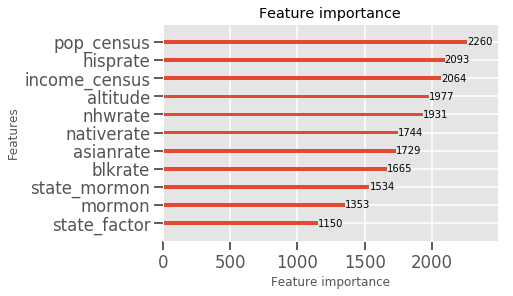

In [42]:
plot_importance(cat_residual.best_estimator_)
explainer=shap.TreeExplainer(cat_residual.best_estimator_)
shaps=explainer.shap_values(data[x4])

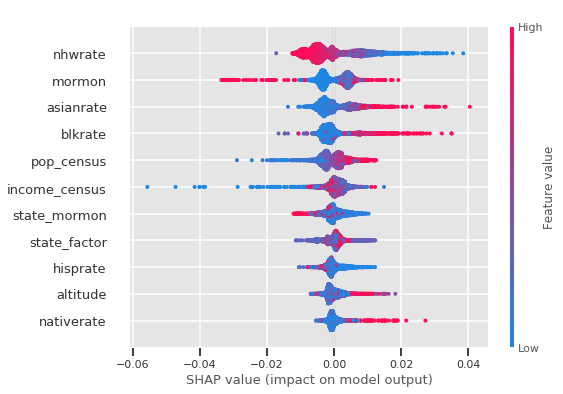

In [43]:
shap.summary_plot(shaps,data[x4])

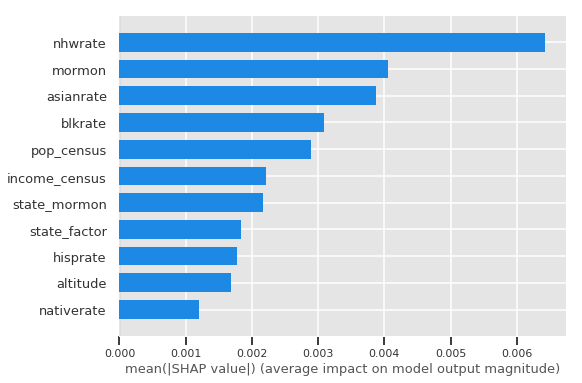

In [44]:
shap.summary_plot(shaps,data[x4],plot_type="bar")

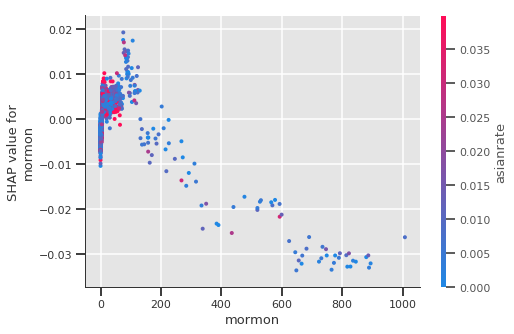

In [48]:
shap.dependence_plot("mormon", shaps,data[x4])

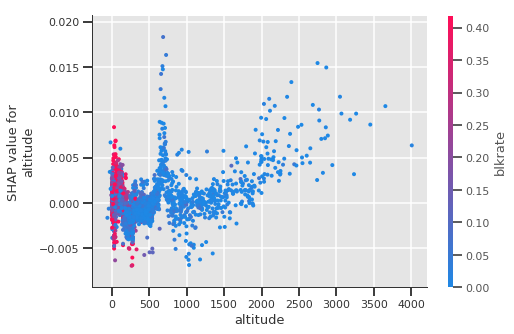

In [49]:
shap.dependence_plot("altitude", shaps,data[x4])

In [47]:
target = data.query('county=="Salt Lake"')[x4]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": cat_residual.predict(target)[0],
        "baseline": data[y].values[0],
        "no_mormons": cat_residual.predict(no_mormons)[0],
        "diff":-cat_residual.predict(target)[0]+cat_residual.predict(no_mormons)[0]
    }
)

predicted    -0.022114
baseline      0.105875
no_mormons   -0.005669
diff          0.016445
dtype: float64

Modeling just the residual leaves us with 1.65pp increase in poverty for Salt Lake City from the absence of mormons